# Sample of correlation analysis

Load libraries and dataset

In [1]:
import pandas as pd
import numpy as np
dataset_to_correlate = pd.read_csv('dataset_kernels_corr.csv', sep=';', dtype={'size vector': 'str'})

Get list of sizes

In [2]:
list_v_sizes = set(dataset_to_correlate[dataset_to_correlate['label']=='Copy']['size vector'])

Declare labels to correlate in each axis

In [3]:
labels_to_correlatey = {'2mm_0',
 '2mm_1',
 '3mm_1',
 '3mm_2',
 'adi_0',
 'adi_1',
 'atax_0',
 'atax_2',
 'doitgen_0',
 'doitgen_1',
 'fdtd-2d_0',
 'fdtd-2d_1',
 'fdtd-2d_2',
 'fdtd-2d_3',
 'gemm',
 'gesummv',
 'heat-3d_0',
 'jacobi-1d_0',
 'jacobi-1d_1',
 'jacobi-2d_0',
 'jacobi-2d_1',
 'mvt_0',
 'mvt_1',
 'syr2k',
 'syrk',
 'trmm'}

In [4]:
labels_to_correlatex = {'Copy', 'Triad','Stride64','Rows','Reduction','matxvec','matxmat','stencil'}


Sort, remove data used to sort and to select entries

In [5]:
def clean_and_flaten_to_correlate(dataset_to_clean):
    dataset_to_plot = dataset_to_clean.copy()
    dataset_to_plot = dataset_to_plot.sort_values(['size vector','threads','affinity','id'])
    del dataset_to_plot['id']
    del dataset_to_plot['size vector']
    del dataset_to_plot['threads']
    del dataset_to_plot['affinity']
    del dataset_to_plot['label']
    return dataset_to_plot.values.ravel()

Apply correlation analysis

In [6]:
import seaborn as sns
import math
from scipy.stats.stats import pearsonr   
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
from scipy.stats.stats import kendalltau

#Create correlation analysis matrices and one for the correlated size
max_corr_matrix = np.zeros((len(labels_to_correlatey),len(labels_to_correlatex)))
max_corr_matrixk = np.zeros((len(labels_to_correlatey),len(labels_to_correlatex)))
correlation_size = pd.DataFrame(index=labels_to_correlatey, columns=labels_to_correlatex)


#For each size 
for size_v in sorted(list_v_sizes):
    corr_matrix = np.zeros((len(labels_to_correlatey),len(labels_to_correlatex)))

    y = 0
    x = 0

    print(size_v)
    #For each label in axis y
    for y_label in labels_to_correlatey:
        #Filter data by label and later by size
        dataset_y = dataset_to_correlate[dataset_to_correlate['label']==y_label].copy()
        dataset_y = dataset_y[(dataset_y['size vector']== 'unk')]
        dataset_y_flat = clean_and_flaten_to_correlate(dataset_y)
        
        #For each label in axis y
        for x_label in labels_to_correlatex:          
            #Filter data by label and later by size
            dataset_x = dataset_to_correlate[dataset_to_correlate['label']==x_label].copy()
            dataset_x = dataset_x[(dataset_x['size vector']== size_v)|(dataset_x['size vector']== 'unk')]
            dataset_x_flat = clean_and_flaten_to_correlate(dataset_x)

            #Apply correlation analysis for spearman
            p_v = spearmanr(dataset_y_flat,dataset_x_flat)
            corr_matrix[y][x]= p_v[0]
            max_corr = max(max_corr_matrix[y][x], p_v[0])
            #To decrease execution time, apply kendall if matrix is updated
            if max_corr == p_v[0] :
                max_corr_matrix[y][x] = p_v[0]
                p_v = kendalltau(dataset_y_flat,dataset_x_flat, method='auto')
                max_corr_matrixk[y][x] = p_v[0]

                correlation_size.at[y_label, x_label] = size_v
            x = x + 1
        y = y + 1   
        x = 0

1000
10000
100000
1000000
100000000
120000000
140000000
160000000
180000000
2000
20000
200000
2000000
20000000
200000000
3000
30000
300000
3000000
4000
40000
400000
40000000
5000
50000
500000
5000000
6000
60000
600000
60000000
7000
70000
700000
7000000
8000
80000
800000
80000000
9000
90000
900000
9000000


Enforce column ordering and sort rows per name

In [7]:
def create_corr_mat_in(mat_in):
    max_corr_matrix_aux = np.round(mat_in, decimals=2)
    df_corr = pd.DataFrame(max_corr_matrix_aux,index=labels_to_correlatey, columns=labels_to_correlatex)
    df_corr = df_corr[['Copy', 'Triad','Stride64','Rows','Reduction','matxvec','matxmat','stencil']]
    df_corr = df_corr.sort_index(axis = 0) 
    return df_corr


In [8]:
mat_k = create_corr_mat_in(max_corr_matrixk)

In [9]:
mat_s = create_corr_mat_in(max_corr_matrix)

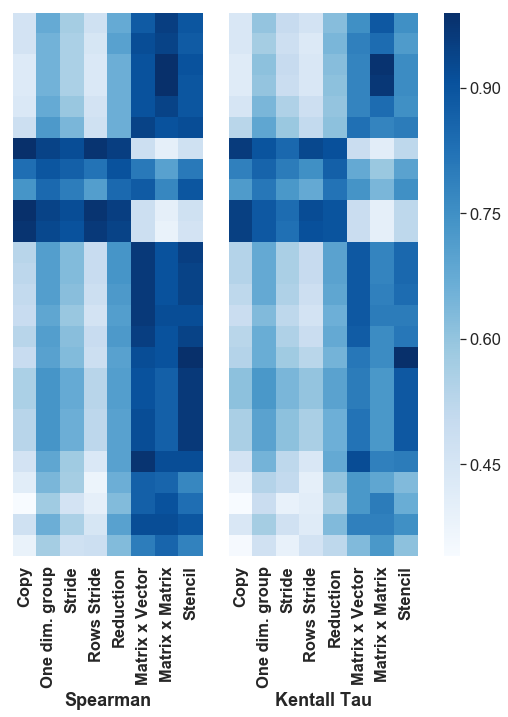

In [10]:
import seaborn  as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
f,(ax1,ax3, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1,1,0.08]}, figsize=(8,10))
ax1.get_shared_y_axes().join(ax3)
g1 = sns.heatmap(mat_s, yticklabels=False, xticklabels=['Copy','One dim. group','Stride','Rows Stride', 'Reduction','Matrix x Vector', 'Matrix x Matrix', 'Stencil'],cmap="Blues",cbar=False,ax=ax1)
#g1 = sns.heatmap(mat_s, yticklabels=False, cmap="Blues",cbar=False,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Spearman', weight='bold')
g3 = sns.heatmap(mat_k, yticklabels=False, xticklabels=['Copy','One dim. group','Stride','Rows Stride', 'Reduction','Matrix x Vector', 'Matrix x Matrix', 'Stencil'],cmap="Blues",ax=ax3, cbar_ax=axcb)
#g3 = sns.heatmap(mat_k, yticklabels=False, cmap="Blues",ax=ax3, cbar_ax=axcb)
g3.set_ylabel('')
g3.set_xlabel('Kentall Tau', weight='bold')
g3.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90, weight='bold')
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0, weight='bold')

plt.show()